# 📦 Import bibliotek i konfiguracja środowiska

W tej sekcji importujemy wszystkie niezbędne biblioteki do pracy z modelem YOLO, przetwarzania obrazów oraz zarządzania plikami.

In [ ]:
import os
import shutil
from pathlib import Path
import matplotlib.pyplot as plt

In [ ]:


# Katalog źródłowy i docelowy
source_dir = Path("NAUKA")
dest_dir = Path("NAUKA_filtered")

# Utwórz nowy katalog główny
dest_dir.mkdir(exist_ok=True)

# Utwórz podfoldery dla "brudne" i "czyste"
(dest_dir / "brudne").mkdir(exist_ok=True)
(dest_dir / "czyste").mkdir(exist_ok=True)

# Przejdź przez wszystkie foldery w strukturze
for root, dirs, files in os.walk(source_dir):
    # Skopiuj tylko pliki Z "czarno" w nazwie
    for file in files:
        if "czarno" in file.lower() and file.endswith('.bmp'):
            src_file = Path(root) / file
            
            # Określ czy to "brudne" czy "czyste"
            if "brudne" in root:
                dst_file = dest_dir / "brudne" / file
            elif "czyste" in root:
                dst_file = dest_dir / "czyste" / file
            else:
                continue
                
            shutil.copy2(src_file, dst_file)
            print(f"Skopiowano: {src_file} -> {dst_file}")

print(f"\nGotowe! Nowa struktura została utworzona w folderze: {dest_dir}")


Skopiowano: NAUKA/brudne/202511190106/48001F003202511190106 czarno.bmp -> NAUKA_filtered/brudne/48001F003202511190106 czarno.bmp
Skopiowano: NAUKA/brudne/202511190058/48001F003202511190058 czarno.bmp -> NAUKA_filtered/brudne/48001F003202511190058 czarno.bmp
Skopiowano: NAUKA/brudne/202511190117/48001F003202511190117 czarno.bmp -> NAUKA_filtered/brudne/48001F003202511190117 czarno.bmp
Skopiowano: NAUKA/brudne/202511190100/48001F003202511190100 czarno.bmp -> NAUKA_filtered/brudne/48001F003202511190100 czarno.bmp
Skopiowano: NAUKA/brudne/202511190073/48001F003202511190073 czarno.bmp -> NAUKA_filtered/brudne/48001F003202511190073 czarno.bmp
Skopiowano: NAUKA/brudne/202511190048/48001F003202511190048 czarno.bmp -> NAUKA_filtered/brudne/48001F003202511190048 czarno.bmp
Skopiowano: NAUKA/brudne/202511190063/48001F003202511190063 czarno.bmp -> NAUKA_filtered/brudne/48001F003202511190063 czarno.bmp
Skopiowano: NAUKA/brudne/202511190093/48001F003202511190093 czarno.bmp -> NAUKA_filtered/brudne/4

In [3]:
import cv2
import numpy as np


def crop_white_background(image_path, threshold=240, padding=5, background_ratio=0.95, edge_scan_depth=10):
    """
    Przycina obraz w skali szarości usuwając białe tło.
    
    Args:
        image_path: Ścieżka do obrazu lub sam obraz (numpy array)
        threshold: Próg jasności - piksele jaśniejsze niż ta wartość są uważane za tło (0-255)
        padding: Dodatkowy margines wokół zawartości (w pikselach)
        background_ratio: Jaki procent pikseli w rzędzie/kolumnie musi być tłem, aby uznać ją za pustą (0-1)
        edge_scan_depth: Ile kolejnych rzędów/kolumn od krawędzi musi być tłem, aby uznać je za puste
    
    Returns:
        Przycięty obraz (numpy array)
    """
    # Wczytaj obraz jeśli podano ścieżkę
    if isinstance(image_path, str):
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            raise ValueError(f"Nie można wczytać obrazu: {image_path}")
    else:
        img = image_path
    
    h, w = img.shape
    
    # Znajdź maski tła
    background_mask = img >= threshold
    
    # Sprawdź każdy rząd - ile procent to tło
    row_background_ratio = background_mask.mean(axis=1)
    
    # Sprawdź każdą kolumnę - ile procent to tło
    col_background_ratio = background_mask.mean(axis=0)
    
    # Znajdź pierwszy rząd z góry, od którego zaczyna się zawartość
    # Ignorujemy pojedyncze odstające piksele przy krawędziach
    y_min = 0
    i = 0
    while i < h - edge_scan_depth:
        # Sprawdź następne edge_scan_depth rzędów
        next_rows = row_background_ratio[i:i+edge_scan_depth]
        # Jeśli większość (co najmniej 70%) to tło, uznaj za tło
        if np.sum(next_rows >= background_ratio) >= edge_scan_depth * 0.7:
            y_min = i + edge_scan_depth
            i += edge_scan_depth
        else:
            break
    
    # Znajdź ostatni rząd od dołu
    y_max = h
    i = h - 1
    while i >= edge_scan_depth:
        start_idx = max(0, i - edge_scan_depth + 1)
        prev_rows = row_background_ratio[start_idx:i+1]
        if np.sum(prev_rows >= background_ratio) >= edge_scan_depth * 0.7:
            y_max = start_idx
            i -= edge_scan_depth
        else:
            break
    
    # Znajdź pierwszą kolumnę z lewej
    x_min = 0
    i = 0
    while i < w - edge_scan_depth:
        next_cols = col_background_ratio[i:i+edge_scan_depth]
        if np.sum(next_cols >= background_ratio) >= edge_scan_depth * 0.7:
            x_min = i + edge_scan_depth
            i += edge_scan_depth
        else:
            break
    
    # Znajdź ostatnią kolumnę z prawej
    x_max = w
    i = w - 1
    while i >= edge_scan_depth:
        start_idx = max(0, i - edge_scan_depth + 1)
        prev_cols = col_background_ratio[start_idx:i+1]
        if np.sum(prev_cols >= background_ratio) >= edge_scan_depth * 0.7:
            x_max = start_idx
            i -= edge_scan_depth
        else:
            break
    
    # Dodaj padding
    y_min = max(0, y_min - padding)
    y_max = min(h, y_max + padding)
    x_min = max(0, x_min - padding)
    x_max = min(w, x_max + padding)
    
    # Przytnij obraz
    cropped = img[y_min:y_max, x_min:x_max]
    
    return cropped


def crop_and_save(input_path, output_path, threshold=240, padding=5, background_ratio=0.95, edge_scan_depth=10):
    """
    Przycina obraz i zapisuje wynik do pliku.
    
    Args:
        input_path: Ścieżka do obrazu wejściowego
        output_path: Ścieżka zapisu przyciętego obrazu
        threshold: Próg jasności dla tła
        padding: Margines wokół zawartości
        background_ratio: Jaki procent pikseli w rzędzie/kolumnie musi być tłem
        edge_scan_depth: Głębokość skanowania od krawędzi
    """
    img = cv2.imread(input_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"Nie można wczytać obrazu: {input_path}")
    
    cropped = crop_white_background(img, threshold, padding, background_ratio, edge_scan_depth)
    cv2.imwrite(output_path, cropped)
    
    return cropped


import os
from pathlib import Path


def process_directory(input_dir, output_dir, threshold=240, padding=5, background_ratio=0.95, edge_scan_depth=10):
    """
    Przetwarza wszystkie obrazy BMP w katalogu i zapisuje przycięte wersje.
    
    Args:
        input_dir: Ścieżka do katalogu wejściowego
        output_dir: Ścieżka do katalogu wyjściowego
        threshold: Próg jasności dla tła
        padding: Margines wokół zawartości
        background_ratio: Jaki procent pikseli w rzędzie/kolumnie musi być tłem
        edge_scan_depth: Głębokość skanowania od krawędzi
    """
    input_path = Path(input_dir)
    output_path = Path(output_dir)
    
    # Utwórz katalog wyjściowy jeśli nie istnieje
    output_path.mkdir(parents=True, exist_ok=True)
    
    # Znajdź wszystkie pliki BMP
    bmp_files = list(input_path.glob("*.bmp"))
    
    if not bmp_files:
        print(f"Nie znaleziono plików BMP w {input_dir}")
        return
    
    print(f"Znaleziono {len(bmp_files)} plików BMP w {input_dir}")
    
    success_count = 0
    error_count = 0
    
    for i, input_file in enumerate(bmp_files, 1):
        output_file = output_path / input_file.name
        
        try:
            result = crop_and_save(
                str(input_file), 
                str(output_file), 
                threshold=threshold, 
                padding=padding, 
                background_ratio=background_ratio,
                edge_scan_depth=edge_scan_depth
            )
            
            original_shape = cv2.imread(str(input_file), cv2.IMREAD_GRAYSCALE).shape
            print(f"[{i}/{len(bmp_files)}] {input_file.name}: {original_shape} → {result.shape}")
            success_count += 1
            
        except Exception as e:
            print(f"[{i}/{len(bmp_files)}] Błąd przy {input_file.name}: {e}")
            error_count += 1
    
    print(f"\nPrzetworzono: {success_count} plików")
    if error_count > 0:
        print(f"Błędów: {error_count}")



print("=" * 60)
print("Przetwarzanie data/czyste...")
print("=" * 60)
process_directory("NAUKA_filtered/czyste", "data_cropped/czyste")
    

print("\n" + "=" * 60)
print("Przetwarzanie data/brudne...")
print("=" * 60)
process_directory("NAUKA_filtered/brudne", "data_cropped/brudne")


Przetwarzanie data/czyste...
Znaleziono 64 plików BMP w NAUKA_filtered/czyste
[1/64] 48001F003202511180048 czarno.bmp: (1250, 1967) → (545, 1287)
[2/64] 48001F003202511180045 czarno.bmp: (1250, 1949) → (545, 1289)
[3/64] 48001F003202511180057 czarno.bmp: (1250, 1939) → (445, 1199)
[4/64] 48001F003202511180073 czarno.bmp: (1250, 1752) → (445, 1192)
[5/64] 48001F003202511180021 czarno.bmp: (1250, 2164) → (595, 1534)
[6/64] 48001F003202511180074 czarno.bmp: (1250, 2196) → (515, 1286)
[7/64] 48001F003202511180077 czarno.bmp: (1250, 1323) → (455, 1158)
[8/64] 48001F003202511180034 czarno.bmp: (1250, 4356) → (585, 1746)
[9/64] 48001F003202511180038 czarno.bmp: (1250, 4356) → (585, 1736)
[10/64] 48001F003202511180025 czarno.bmp: (1250, 4356) → (575, 1526)
[11/64] 48001F003202511180035 czarno.bmp: (1250, 4356) → (585, 1746)
[12/64] 48001F003202511180027 czarno.bmp: (1250, 4358) → (585, 1528)
[13/64] 48001F003202511190015 czarno.bmp: (1250, 2393) → (515, 1283)
[14/64] 48001F003202511180029 czar

In [4]:
import cv2
import numpy as np
from pathlib import Path


def detect_car_orientation(image_path):
    """
    Wykrywa orientację samochodu na podstawie rozkładu ciemnych pikseli.
    Zakłada, że przód samochodu (koła, silnik) jest ciemniejszy niż tył.
    
    Args:
        image_path: Ścieżka do obrazu lub sam obraz (numpy array)
    
    Returns:
        'left' jeśli przód jest po lewej, 'right' jeśli po prawej
    """
    # Wczytaj obraz jeśli podano ścieżkę
    if isinstance(image_path, str):
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            raise ValueError(f"Nie można wczytać obrazu: {image_path}")
    else:
        img = image_path
    
    h, w = img.shape
    
    # Podziel obraz na lewą i prawą połowę
    left_half = img[:, :w//2]
    right_half = img[:, w//2:]
    
    # Oblicz średnią jasność dla każdej połowy
    # Niższa wartość = ciemniejsze = więcej zawartości (koła, silnik)
    left_mean = left_half.mean()
    right_mean = right_half.mean()
    
    # Alternatywnie: policz ciemne piksele (< 200)
    left_dark_pixels = np.sum(left_half < 200)
    right_dark_pixels = np.sum(right_half < 200)
    
    # Przód jest tam gdzie więcej ciemnych pikseli
    if left_dark_pixels > right_dark_pixels:
        return 'left'
    else:
        return 'right'


def orient_car(image_path, target_orientation='right'):
    """
    Orientuje obraz samochodu tak, aby przód był po wskazanej stronie.
    
    Args:
        image_path: Ścieżka do obrazu lub sam obraz (numpy array)
        target_orientation: 'left' lub 'right' - gdzie ma być przód
    
    Returns:
        Obraz z odpowiednią orientacją (numpy array)
    """
    # Wczytaj obraz jeśli podano ścieżkę
    if isinstance(image_path, str):
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            raise ValueError(f"Nie można wczytać obrazu: {image_path}")
    else:
        img = image_path
    
    # Wykryj aktualną orientację
    current_orientation = detect_car_orientation(img)
    
    # Jeśli trzeba, odwróć obraz
    if current_orientation != target_orientation:
        img = cv2.flip(img, 1)  # flip horizontally (1 = horizontal, 0 = vertical)
        return img, True  # True = flipped
    
    return img, False  # False = not flipped


def orient_and_save(input_path, output_path, target_orientation='right'):
    """
    Orientuje obraz i zapisuje wynik do pliku.
    
    Args:
        input_path: Ścieżka do obrazu wejściowego
        output_path: Ścieżka zapisu zorientowanego obrazu
        target_orientation: 'left' lub 'right' - gdzie ma być przód
    
    Returns:
        (oriented_image, was_flipped)
    """
    img = cv2.imread(input_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"Nie można wczytać obrazu: {input_path}")
    
    oriented, flipped = orient_car(img, target_orientation)
    cv2.imwrite(output_path, oriented)
    
    return oriented, flipped


def process_directory(input_dir, output_dir, target_orientation='right'):
    """
    Przetwarza wszystkie obrazy BMP w katalogu i orientuje je.
    
    Args:
        input_dir: Ścieżka do katalogu wejściowego
        output_dir: Ścieżka do katalogu wyjściowego
        target_orientation: 'left' lub 'right' - gdzie ma być przód
    """
    input_path = Path(input_dir)
    output_path = Path(output_dir)
    
    # Utwórz katalog wyjściowy jeśli nie istnieje
    output_path.mkdir(parents=True, exist_ok=True)
    
    # Znajdź wszystkie pliki BMP
    bmp_files = list(input_path.glob("*.bmp"))
    
    if not bmp_files:
        print(f"Nie znaleziono plików BMP w {input_dir}")
        return
    
    print(f"Znaleziono {len(bmp_files)} plików BMP w {input_dir}")
    
    success_count = 0
    flipped_count = 0
    error_count = 0
    
    for i, input_file in enumerate(bmp_files, 1):
        output_file = output_path / input_file.name
        
        try:
            oriented, flipped = orient_and_save(
                str(input_file), 
                str(output_file), 
                target_orientation=target_orientation
            )
            
            status = "odwrócono" if flipped else "bez zmian"
            print(f"[{i}/{len(bmp_files)}] {input_file.name}: {status}")
            success_count += 1
            if flipped:
                flipped_count += 1
            
        except Exception as e:
            print(f"[{i}/{len(bmp_files)}] Błąd przy {input_file.name}: {e}")
            error_count += 1
    
    print(f"\nPrzetworzono: {success_count} plików")
    print(f"Odwrócono: {flipped_count} plików")
    if error_count > 0:
        print(f"Błędów: {error_count}")


print("=" * 60)
print("Orientowanie data_cropped/czyste...")
print("=" * 60)
process_directory("data_cropped/czyste", "data_oriented/czyste", target_orientation='right')

print("\n" + "=" * 60)
print("Orientowanie data_cropped/brudne...")
print("=" * 60)
process_directory("data_cropped/brudne", "data_oriented/brudne", target_orientation='right')


Orientowanie data_cropped/czyste...
Znaleziono 64 plików BMP w data_cropped/czyste
[1/64] 48001F003202511180048 czarno.bmp: odwrócono
[2/64] 48001F003202511180045 czarno.bmp: bez zmian
[3/64] 48001F003202511180057 czarno.bmp: bez zmian
[4/64] 48001F003202511180073 czarno.bmp: odwrócono
[5/64] 48001F003202511180021 czarno.bmp: odwrócono
[6/64] 48001F003202511180074 czarno.bmp: odwrócono
[7/64] 48001F003202511180077 czarno.bmp: bez zmian
[8/64] 48001F003202511180034 czarno.bmp: bez zmian
[9/64] 48001F003202511180038 czarno.bmp: bez zmian
[10/64] 48001F003202511180025 czarno.bmp: odwrócono
[11/64] 48001F003202511180035 czarno.bmp: odwrócono
[12/64] 48001F003202511180027 czarno.bmp: odwrócono
[13/64] 48001F003202511190015 czarno.bmp: odwrócono
[14/64] 48001F003202511180029 czarno.bmp: odwrócono
[15/64] 48001F003202511190001 czarno.bmp: bez zmian
[16/64] 48001F003202511180028 czarno.bmp: bez zmian
[17/64] 48001F003202511190011 czarno.bmp: odwrócono
[18/64] 48001F003202511190014 czarno.bmp: 

# 🏷️ Przygotowanie danych

**Przepływ danych:**
- `brudne` → ręczne labelowanie w LabelMe → `images`

Obrazy z folderu "brudne" są ręcznie oznaczane za pomocą narzędzia LabelMe, a wyniki zapisywane w folderze `images`.

## 🔄 Konwersja z formatu LabelMe do YOLO

Poniższy kod konwertuje adnotacje z formatu LabelMe (JSON) do formatu YOLO (pliki .txt z normalizowanymi współrzędnymi bounding boxów).

In [10]:
#!/usr/bin/env python3
"""
Konwersja anotacji LabelMe (JSON) na format YOLO.
Przetwarza tylko zdjęcia z labelami, pomija obrazy bez adnotacji.
"""

import os
import json
import glob
import shutil
from pathlib import Path
from PIL import Image

# Ścieżki
SCRIPT_DIR = os.path.dirname('.')
INPUT_DIR = os.path.join(SCRIPT_DIR, 'images')
OUTPUT_DIR = os.path.join(SCRIPT_DIR, 'yolo_dataset')
TRAIN_RATIO = 0.8  # 80% train, 20% val

# Mapowanie klas (dodaj więcej jeśli potrzeba)
CLASS_MAPPING = {
    'bottle': 0,
    #'bottle2': 1, #jednak gaśnica xd
    'box': 1,
    'crate': 2,
    'crowbar': 5,
    #'evilsquare': 5,
    'grenade': 3,
    'scissors': 4,
}


def convert_labelme_to_yolo(json_path):
    """Konwertuje pojedynczy plik JSON z LabelMe na format YOLO."""
    with open(json_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    
    # Pobierz wymiary obrazu
    img_width = data.get('imageWidth')
    img_height = data.get('imageHeight')
    
    if not img_width or not img_height:
        # Spróbuj wczytać z obrazu
        img_path = data.get('imagePath', '')
        if img_path:
            # imagePath może być relatywną ścieżką, znajdź faktyczny obraz
            json_dir = os.path.dirname(json_path)
            json_base = os.path.splitext(os.path.basename(json_path))[0]
            
            # Szukaj obrazu z tym samym basename
            for ext in ['.bmp', '.jpg', '.png', '.jpeg']:
                potential_img = os.path.join(json_dir, json_base + ext)
                if os.path.exists(potential_img):
                    try:
                        with Image.open(potential_img) as img:
                            img_width, img_height = img.size
                        break
                    except Exception as e:
                        print(f"Błąd odczytu obrazu {potential_img}: {e}")
                        continue
    
    if not img_width or not img_height:
        print(f"Nie można określić wymiarów dla {json_path}")
        return None, None
    
    # Przetwórz wszystkie shape'y
    yolo_lines = []
    shapes = data.get('shapes', [])
    
    if not shapes:
        return None, None  # Brak anotacji
    
    for shape in shapes:
        label = shape.get('label', '').lower()
        
        # Mapuj label na class_id
        if label not in CLASS_MAPPING:
            print(f"Nieznana klasa '{label}' w {json_path}, pomijam")
            continue
        
        class_id = CLASS_MAPPING[label]
        points = shape.get('points', [])
        
        if not points:
            continue
        
        # Oblicz bounding box z punktów (dla rectangle lub polygon)
        xs = [p[0] for p in points]
        ys = [p[1] for p in points]
        
        x_min = min(xs)
        x_max = max(xs)
        y_min = min(ys)
        y_max = max(ys)
        
        # Konwersja do formatu YOLO (znormalizowane środek + szerokość/wysokość)
        x_center = (x_min + x_max) / 2.0 / img_width
        y_center = (y_min + y_max) / 2.0 / img_height
        width = (x_max - x_min) / img_width
        height = (y_max - y_min) / img_height
        
        # Sprawdź poprawność wartości
        if 0 <= x_center <= 1 and 0 <= y_center <= 1 and 0 < width <= 1 and 0 < height <= 1:
            yolo_lines.append(f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}")
        else:
            print(f"Nieprawidłowe wartości bbox w {json_path}: {x_center}, {y_center}, {width}, {height}")
    
    return yolo_lines, (img_width, img_height)


def main():
    """Główna funkcja konwertująca cały dataset."""
    
    # Utwórz strukturę katalogów YOLO
    train_img_dir = os.path.join(OUTPUT_DIR, 'images', 'train')
    val_img_dir = os.path.join(OUTPUT_DIR, 'images', 'val')
    train_lbl_dir = os.path.join(OUTPUT_DIR, 'labels', 'train')
    val_lbl_dir = os.path.join(OUTPUT_DIR, 'labels', 'val')
    
    for d in [train_img_dir, val_img_dir, train_lbl_dir, val_lbl_dir]:
        os.makedirs(d, exist_ok=True)
    
    # Znajdź wszystkie pliki JSON
    json_files = sorted(glob.glob(os.path.join(INPUT_DIR, '*.json')))
    
    if not json_files:
        print(f"Nie znaleziono plików JSON w {INPUT_DIR}")
        return
    
    print(f"Znaleziono {len(json_files)} plików JSON")
    
    processed = 0
    skipped = 0
    
    # Przetwórz każdy plik JSON
    valid_samples = []
    
    for json_path in json_files:
        yolo_lines, img_dims = convert_labelme_to_yolo(json_path)
        
        if not yolo_lines:
            skipped += 1
            continue
        
        # Znajdź odpowiedni plik obrazu
        json_base = os.path.splitext(os.path.basename(json_path))[0]
        img_path = None
        
        for ext in ['.bmp', '.jpg', '.png', '.jpeg']:
            potential_img = os.path.join(INPUT_DIR, json_base + ext)
            if os.path.exists(potential_img):
                img_path = potential_img
                break
        
        if not img_path:
            print(f"Nie znaleziono obrazu dla {json_path}")
            skipped += 1
            continue
        
        valid_samples.append({
            'img_path': img_path,
            'yolo_lines': yolo_lines,
            'basename': json_base,
            'ext': os.path.splitext(img_path)[1]
        })
        
        processed += 1
    
    # Podziel na train/val
    import random
    random.seed(42)
    random.shuffle(valid_samples)
    
    split_idx = int(len(valid_samples) * TRAIN_RATIO)
    train_samples = valid_samples[:split_idx]
    val_samples = valid_samples[split_idx:]
    
    print(f"\nPodział: {len(train_samples)} train, {len(val_samples)} val")
    
    # Kopiuj pliki do odpowiednich katalogów
    for samples, img_dir, lbl_dir, split_name in [
        (train_samples, train_img_dir, train_lbl_dir, 'train'),
        (val_samples, val_img_dir, val_lbl_dir, 'val')
    ]:
        for sample in samples:
            # Kopiuj obraz
            dst_img = os.path.join(img_dir, sample['basename'] + sample['ext'])
            shutil.copy2(sample['img_path'], dst_img)
            
            # Zapisz etykiety YOLO
            dst_lbl = os.path.join(lbl_dir, sample['basename'] + '.txt')
            with open(dst_lbl, 'w', encoding='utf-8') as f:
                f.write('\n'.join(sample['yolo_lines']))
    
    # Utwórz plik classes.txt
    classes_file = os.path.join(OUTPUT_DIR, 'classes.txt')
    sorted_classes = sorted(CLASS_MAPPING.items(), key=lambda x: x[1])
    with open(classes_file, 'w', encoding='utf-8') as f:
        for class_name, _ in sorted_classes:
            f.write(f"{class_name}\n")
    
    # Utwórz plik konfiguracyjny YAML dla YOLO
    yaml_content = f"""# Dataset configuration for YOLO
path: {os.path.abspath(OUTPUT_DIR)}
train: images/train
val: images/val

# Number of classes
nc: {len(CLASS_MAPPING)}

# Class names
names: {[name for name, _ in sorted_classes]}
"""
    
    yaml_file = os.path.join(OUTPUT_DIR, 'data.yaml')
    with open(yaml_file, 'w', encoding='utf-8') as f:
        f.write(yaml_content)
    
    print(f"\n✓ Konwersja zakończona!")
    print(f"  Przetworzone: {processed}")
    print(f"  Pominięte (brak anotacji): {skipped}")
    print(f"\nWygenerowane pliki:")
    print(f"  Dataset: {OUTPUT_DIR}/")
    print(f"  Config: {yaml_file}")
    print(f"  Classes: {classes_file}")



main()


Znaleziono 60 plików JSON
Nieznana klasa 'bottle2' w images/48001F003202511190067 czarno.json, pomijam
Nieznana klasa 'bottle2' w images/48001F003202511190071 czarno.json, pomijam
Nieznana klasa 'evilsquare' w images/48001F003202511190071 czarno.json, pomijam
Nieznana klasa 'evilsquare' w images/48001F003202511190074 czarno.json, pomijam
Nieznana klasa 'evilsquare' w images/48001F003202511190075 czarno.json, pomijam
Nieznana klasa 'evilsquare' w images/48001F003202511190078 czarno.json, pomijam
Nieznana klasa 'evilsquare' w images/48001F003202511190079 czarno.json, pomijam
Nieznana klasa 'evilsquare' w images/48001F003202511190082 czarno.json, pomijam
Nieznana klasa 'evilsquare' w images/48001F003202511190086 czarno.json, pomijam
Nieznana klasa 'evilsquare' w images/48001F003202511190087 czarno.json, pomijam
Nieznana klasa 'evilsquare' w images/48001F003202511190090 czarno.json, pomijam
Nieznana klasa 'evilsquare' w images/48001F003202511190091 czarno.json, pomijam
Nieznana klasa 'evil

# 🎨 Augmentacja danych

W tej sekcji wykonujemy rozszerzenie zbioru danych poprzez różne techniki augmentacji (rotacje, odbicia, zmiana jasności, itp.), aby zwiększyć ilość danych treningowych i poprawić generalizację modelu.

In [12]:
#!/usr/bin/env python3
"""
Rozszerzenie datasetu YOLO przez augmentację.
Generuje dodatkowe warianty zdjęć z transformacjami.
"""

import os
import cv2
import numpy as np
import glob
import random
from pathlib import Path

# Parametry
YOLO_DATASET_DIR = 'yolo_dataset'
AUGMENTATIONS_PER_IMAGE = 12  # Ile wersji każdego obrazu wygenerować
SEED = 2137

random.seed(SEED)
np.random.seed(SEED)


def load_yolo_labels(label_path):
    """Wczytaj etykiety YOLO z pliku."""
    boxes = []
    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) == 5:
                    class_id = int(parts[0])
                    x_center, y_center, width, height = map(float, parts[1:5])
                    boxes.append([class_id, x_center, y_center, width, height])
    return boxes


def save_yolo_labels(label_path, boxes):
    """Zapisz etykiety YOLO do pliku."""
    with open(label_path, 'w') as f:
        for box in boxes:
            class_id = int(box[0])
            x_center, y_center, width, height = box[1:5]
            f.write(f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")


def augment_image_and_boxes(image, boxes):
    """
    Aplikuje losowe transformacje do obrazu i odpowiednio modyfikuje bounding boxy.
    Zwraca (augmented_image, augmented_boxes).
    """
    h, w = image.shape[:2]
    aug_image = image.copy()
    aug_boxes = [box[:] for box in boxes]  # Kopia
    
    # 1. Horizontal flip (30% szans - mniejszy nacisk)
    if random.random() > 0.7:
        aug_image = cv2.flip(aug_image, 1)
        for box in aug_boxes:
            box[1] = 1.0 - box[1]  # x_center = 1 - x_center
    
    # 2. Brightness & Contrast (20% szans - mniejszy nacisk)
    if random.random() > 0.8:
        alpha = random.uniform(0.8, 1.2)  # Mniejszy zakres kontrastu
        beta = random.randint(-20, 20)     # Mniejszy zakres jasności
        aug_image = cv2.convertScaleAbs(aug_image, alpha=alpha, beta=beta)
    
    # 3. Gaussian Noise (10% szans - minimalny nacisk)
    if random.random() > 0.9:
        noise = np.random.normal(0, 10, aug_image.shape).astype(np.uint8)
        aug_image = cv2.add(aug_image, noise)
    
    # 4. Gaussian Blur (10% szans - minimalny nacisk)
    if random.random() > 0.9:
        kernel_size = random.choice([3, 5])
        aug_image = cv2.GaussianBlur(aug_image, (kernel_size, kernel_size), 0)
    
    # 5. Rotation (90% szans - GŁÓWNY nacisk, większy zakres kątów)
    if random.random() > 0.1:
        angle = random.uniform(-30, 30)  # Zwiększony zakres rotacji
        center = (w // 2, h // 2)
        M = cv2.getRotationMatrix2D(center, angle, 1.0)
        aug_image = cv2.warpAffine(aug_image, M, (w, h), 
                                   borderMode=cv2.BORDER_REFLECT)
        
        # Rotacja bboxów (przybliżenie - zachowujemy prostokąty po rotacji)
        for box in aug_boxes:
            x_c, y_c = box[1] * w, box[2] * h
            box_w, box_h = box[3] * w, box[4] * h
            
            # Rotuj środek
            point = np.array([x_c, y_c, 1.0])
            rotated = M @ point
            
            # Po rotacji bbox może być większy - zwiększamy trochę
            scale_factor = 1.0 + abs(angle) / 90.0 * 0.3
            new_w = min(box_w * scale_factor, w)
            new_h = min(box_h * scale_factor, h)
            
            # Normalizuj z powrotem
            box[1] = max(0.0, min(1.0, rotated[0] / w))
            box[2] = max(0.0, min(1.0, rotated[1] / h))
            box[3] = max(0.01, min(1.0, new_w / w))
            box[4] = max(0.01, min(1.0, new_h / h))
    
    # 6. Shift (60% szans - umiarkowany nacisk)
    if random.random() > 0.4:
        shift_x = random.randint(-int(w * 0.15), int(w * 0.15))  # Większy zakres
        shift_y = random.randint(-int(h * 0.15), int(h * 0.15))
        M = np.float32([[1, 0, shift_x], [0, 1, shift_y]])
        aug_image = cv2.warpAffine(aug_image, M, (w, h),
                                   borderMode=cv2.BORDER_REFLECT)
        
        for box in aug_boxes:
            box[1] = max(0.0, min(1.0, box[1] + shift_x / w))
            box[2] = max(0.0, min(1.0, box[2] + shift_y / h))
    
    # 7. Scale (70% szans - zwiększony nacisk)
    if random.random() > 0.3:
        scale = random.uniform(0.7, 1.3)  # Większy zakres skalowania
        new_w, new_h = int(w * scale), int(h * scale)
        aug_image = cv2.resize(aug_image, (new_w, new_h))
        
        # Crop/pad do oryginalnego rozmiaru
        if scale > 1.0:  # Crop
            start_x = (new_w - w) // 2
            start_y = (new_h - h) // 2
            aug_image = aug_image[start_y:start_y+h, start_x:start_x+w]
            
            # Adjust boxes
            for box in aug_boxes:
                box[1] = (box[1] * scale - start_x / w)
                box[2] = (box[2] * scale - start_y / h)
                box[3] = box[3] * scale
                box[4] = box[4] * scale
        else:  # Pad
            pad_x = (w - new_w) // 2
            pad_y = (h - new_h) // 2
            aug_image = cv2.copyMakeBorder(aug_image, pad_y, h-new_h-pad_y, 
                                          pad_x, w-new_w-pad_x, 
                                          cv2.BORDER_REFLECT)
            
            for box in aug_boxes:
                box[1] = (box[1] * new_w + pad_x) / w
                box[2] = (box[2] * new_h + pad_y) / h
                box[3] = box[3] * scale
                box[4] = box[4] * scale
        
        # Clamp boxes
        for box in aug_boxes:
            box[1] = max(0.0, min(1.0, box[1]))
            box[2] = max(0.0, min(1.0, box[2]))
            box[3] = max(0.01, min(1.0, box[3]))
            box[4] = max(0.01, min(1.0, box[4]))
    
    # Filtruj boxy poza obrazem
    valid_boxes = []
    for box in aug_boxes:
        x_c, y_c, bw, bh = box[1:5]
        # Sprawdź czy bbox jest przynajmniej częściowo w obrazie
        if (0 <= x_c <= 1 and 0 <= y_c <= 1 and 
            bw > 0.01 and bh > 0.01 and bw <= 1 and bh <= 1):
            valid_boxes.append(box)
    
    return aug_image, valid_boxes


def augment_split(split_name):
    """Augmentuj dany split (train lub val)."""
    img_dir = os.path.join(YOLO_DATASET_DIR, 'images', split_name)
    lbl_dir = os.path.join(YOLO_DATASET_DIR, 'labels', split_name)
    
    if not os.path.exists(img_dir):
        print(f"Brak katalogu {img_dir}")
        return
    
    # Znajdź wszystkie obrazy
    image_files = []
    for ext in ['*.bmp', '*.jpg', '*.png', '*.jpeg']:
        image_files.extend(glob.glob(os.path.join(img_dir, ext)))
    
    if not image_files:
        print(f"Brak obrazów w {img_dir}")
        return
    
    print(f"\n{split_name.upper()}: Augmentuję {len(image_files)} obrazów...")
    
    augmented_count = 0
    
    for img_path in image_files:
        basename = os.path.splitext(os.path.basename(img_path))[0]
        ext = os.path.splitext(img_path)[1]
        lbl_path = os.path.join(lbl_dir, basename + '.txt')
        
        # Wczytaj obraz i etykiety
        image = cv2.imread(img_path)
        if image is None:
            print(f"Nie można wczytać {img_path}")
            continue
        
        boxes = load_yolo_labels(lbl_path)
        if not boxes:
            print(f"Brak etykiet dla {basename}, pomijam")
            continue
        
        # Generuj augmentacje
        for i in range(AUGMENTATIONS_PER_IMAGE):
            aug_img, aug_boxes = augment_image_and_boxes(image, boxes)
            
            if not aug_boxes:
                continue  # Pomijamy jeśli wszystkie boxy wyszły poza obraz
            
            # Zapisz augmentowany obraz i etykiety
            aug_basename = f"{basename}_aug{i+1}"
            aug_img_path = os.path.join(img_dir, aug_basename + ext)
            aug_lbl_path = os.path.join(lbl_dir, aug_basename + '.txt')
            
            cv2.imwrite(aug_img_path, aug_img)
            save_yolo_labels(aug_lbl_path, aug_boxes)
            augmented_count += 1
    
    print(f"  ✓ Dodano {augmented_count} augmentowanych obrazów")
    
    # Policz końcową liczbę
    total_images = len(glob.glob(os.path.join(img_dir, '*.*')))
    print(f"  Razem w {split_name}: {total_images} obrazów")


def main():
    """Główna funkcja."""
    script_dir = os.path.dirname('.')
    #os.chdir(script_dir)
    
    if not os.path.exists(YOLO_DATASET_DIR):
        print(f"Brak katalogu {YOLO_DATASET_DIR}. Uruchom najpierw labelme_to_yolo.py")
        return
    
    print("=" * 60)
    print("AUGMENTACJA DATASETU YOLO")
    print("=" * 60)
    print(f"Katalog: {YOLO_DATASET_DIR}")
    print(f"Augmentacji na obraz: {AUGMENTATIONS_PER_IMAGE}")
    
    # Augmentuj train i val
    augment_split('train')
    augment_split('val')
    
    print("\n" + "=" * 60)
    print("✓ AUGMENTACJA ZAKOŃCZONA")
    print("=" * 60)
    print("\nDataset jest gotowy do treningu!")
    print(f"Użyj: yolo task=detect mode=train model=yolov8n.pt \\")
    print(f"       data={YOLO_DATASET_DIR}/data.yaml epochs=100 imgsz=640")


main()


AUGMENTACJA DATASETU YOLO
Katalog: yolo_dataset
Augmentacji na obraz: 12

TRAIN: Augmentuję 48 obrazów...
  ✓ Dodano 576 augmentowanych obrazów
  Razem w train: 624 obrazów

VAL: Augmentuję 12 obrazów...
  ✓ Dodano 576 augmentowanych obrazów
  Razem w train: 624 obrazów

VAL: Augmentuję 12 obrazów...
  ✓ Dodano 144 augmentowanych obrazów
  Razem w val: 156 obrazów

✓ AUGMENTACJA ZAKOŃCZONA

Dataset jest gotowy do treningu!
Użyj: yolo task=detect mode=train model=yolov8n.pt \
       data=yolo_dataset/data.yaml epochs=100 imgsz=640
  ✓ Dodano 144 augmentowanych obrazów
  Razem w val: 156 obrazów

✓ AUGMENTACJA ZAKOŃCZONA

Dataset jest gotowy do treningu!
Użyj: yolo task=detect mode=train model=yolov8n.pt \
       data=yolo_dataset/data.yaml epochs=100 imgsz=640


# 🚀 Trenowanie modelu YOLO

YOLO v8 nano wytrenowany został na przygotowanym datasecie do rozpoznawania:
- butelek (po późniejszej konsultacji to co wzięliśmy za butelki prawdopodobnie jest siekierami)
- podejrzanych skrzyń
- granatów (prawdopodobnie to granaty)
- pudeł
- nożyc (szczypiec)
- łomów

**Model może być dalej fine-tunowany, dodanie kolejnego przedmiotu do rozpoznawania wymaga jedynie między 5 a 10 różnych zdjęć (im więcej tym dokładniej) owego przedmiotu, nie trzeba trenować go od nowa za każdym razem**


## 📊 Macierz pomyłek modelu

![Confusion Matrix](model/confusion_matrix.png)

Macierz pomyłek pokazuje, jak dobrze model rozpoznaje poszczególne klasy obiektów i z jakimi klasami najczęściej je myli.

## Test

Model: model/weights/best.pt
Zdjęcie: test_image.bmp
Próg pewności: 0.4

Wykryto 5 obiektów:

  1. crate: 91.02% pewności
     Pozycja: (750, 264) -> (858, 348)
  2. crowbar: 89.27% pewności
     Pozycja: (1247, 269) -> (1410, 304)
  3. bottle: 88.96% pewności
     Pozycja: (672, 428) -> (732, 461)
  4. grenade: 87.63% pewności
     Pozycja: (365, 372) -> (457, 397)
  5. bottle: 72.73% pewności
     Pozycja: (353, 378) -> (375, 424)

✓ Wynik zapisany: result_test_image.jpg

Wykryto 5 obiektów:

  1. crate: 91.02% pewności
     Pozycja: (750, 264) -> (858, 348)
  2. crowbar: 89.27% pewności
     Pozycja: (1247, 269) -> (1410, 304)
  3. bottle: 88.96% pewności
     Pozycja: (672, 428) -> (732, 461)
  4. grenade: 87.63% pewności
     Pozycja: (365, 372) -> (457, 397)
  5. bottle: 72.73% pewności
     Pozycja: (353, 378) -> (375, 424)

✓ Wynik zapisany: result_test_image.jpg


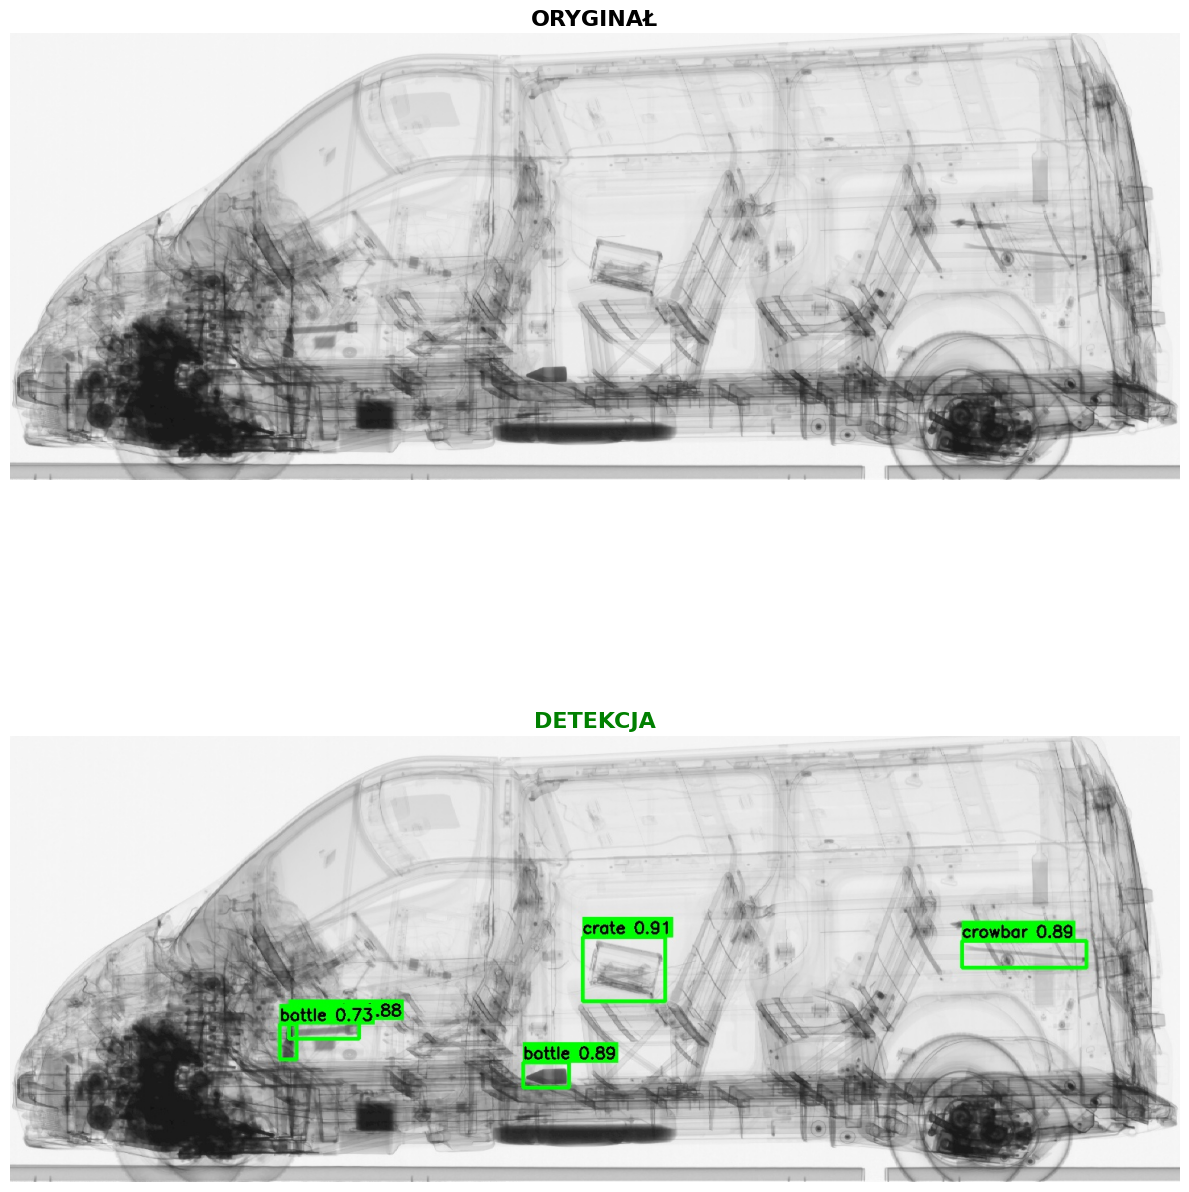

In [5]:
#!/usr/bin/env python3
"""Test modelu YOLO na pojedynczym zdjęciu."""

from ultralytics import YOLO
import cv2
import sys
import os

def predict_image(model_path, image_path, output_path='result.jpg', conf_threshold=0.25):
    """Wykryj obiekty na pojedynczym zdjęciu."""
    
    # Załaduj model
    if not os.path.exists(model_path):
        print(f"Błąd: Brak modelu w {model_path}")
        return
    
    if not os.path.exists(image_path):
        print(f"Błąd: Brak zdjęcia {image_path}")
        return
    
    print("=" * 60)
    print(f"Model: {model_path}")
    print(f"Zdjęcie: {image_path}")
    print(f"Próg pewności: {conf_threshold}")
    print("=" * 60)
    
    model = YOLO(model_path)
    
    # Detekcja
    results = model.predict(
        source=image_path,
        conf=conf_threshold,
        save=False,
        verbose=False
    )
    
    # Wczytaj obraz
    img = cv2.imread(image_path)
    
    # Konwertuj grayscale na BGR jeśli potrzeba
    if len(img.shape) == 2:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    
    result = results[0]
    boxes = result.boxes
    
    print(f"\nWykryto {len(boxes)} obiektów:\n")
    
    # Rysuj każdy bbox
    for i, box in enumerate(boxes):
        cls = int(box.cls[0])
        conf = float(box.conf[0])
        x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
        
        class_name = model.names[cls]
        print(f"  {i+1}. {class_name}: {conf:.2%} pewności")
        print(f"     Pozycja: ({int(x1)}, {int(y1)}) -> ({int(x2)}, {int(y2)})")
        
        # Rysuj prostokąt
        cv2.rectangle(img, (int(x1), int(y1)), (int(x2), int(y2)), 
                     (0, 255, 0), 3)
        
        # Etykieta
        label = f"{class_name} {conf:.2f}"
        label_size, _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.7, 2)
        
        # Tło dla tekstu
        cv2.rectangle(img, (int(x1), int(y1)-label_size[1]-10), 
                     (int(x1)+label_size[0], int(y1)), (0, 255, 0), -1)
        
        # Tekst
        cv2.putText(img, label, (int(x1), int(y1)-5),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 2)
    
    if len(boxes) == 0:
        print("  Brak detekcji")
    
    # Zapisz wynik
    cv2.imwrite(output_path, img)
    print(f"\n✓ Wynik zapisany: {output_path}")
    
    # Wyświetl obraz - przeskaluj jeśli za duży
    h, w = img.shape[:2]
    max_dim = 1200
    if h > max_dim or w > max_dim:
        scale = max_dim / max(h, w)
        new_w, new_h = int(w * scale), int(h * scale)
        display_img = cv2.resize(img, (new_w, new_h))
    else:
        display_img = img
    
    #cv2.imshow('Detekcja - naciśnij dowolny klawisz aby zamknąć', display_img)
    #cv2.waitKey(0)
    #cv2.destroyAllWindows()
    
    print("=" * 60)


def main():
    
    image_path = "test_image.bmp"
    conf = 0.4
    #image_path = "dataset/yolo_dataset/images/val/48001F003202511190110 czarno_aug1.bmp"
    #conf = 0.5
    
    # Domyślna ścieżka do modelu
    model_path = 'model/weights/best.pt'
    
    # Nazwa pliku wyjściowego
    basename = os.path.splitext(os.path.basename(image_path))[0]
    output_path = f"result_{basename}.jpg"
    
    predict_image(model_path, image_path, output_path, conf)
    
    # Wyświetl porównanie: oryginał vs wynik
    original = cv2.imread(image_path)
    result = cv2.imread(output_path)
    
    # Konwertuj grayscale na BGR jeśli potrzeba
    if len(original.shape) == 2:
        original = cv2.cvtColor(original, cv2.COLOR_GRAY2BGR)
    
    # Konwertuj BGR do RGB dla matplotlib
    original_rgb = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
    result_rgb = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
    
    # Wyświetl za pomocą matplotlib
    fig, axes = plt.subplots(2, 1, figsize=(12, 16))
    
    axes[0].imshow(original_rgb)
    axes[0].set_title('ORYGINAŁ', fontsize=16, fontweight='bold')
    axes[0].axis('off')
    
    axes[1].imshow(result_rgb)
    axes[1].set_title('DETEKCJA', fontsize=16, fontweight='bold', color='green')
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()

main()
